# Customer Segmentation: Clustering

### Libraries

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Scikit-Learn libraries

In [95]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # Este no se para que es yet

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics


## Loading DATA

In [96]:
data = pd.read_csv('marketing_campaign.csv', sep='\t')
data.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0


In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Data cleaning

_Let's clean the dataset, check what's missing and what's wrong_

<AxesSubplot:>

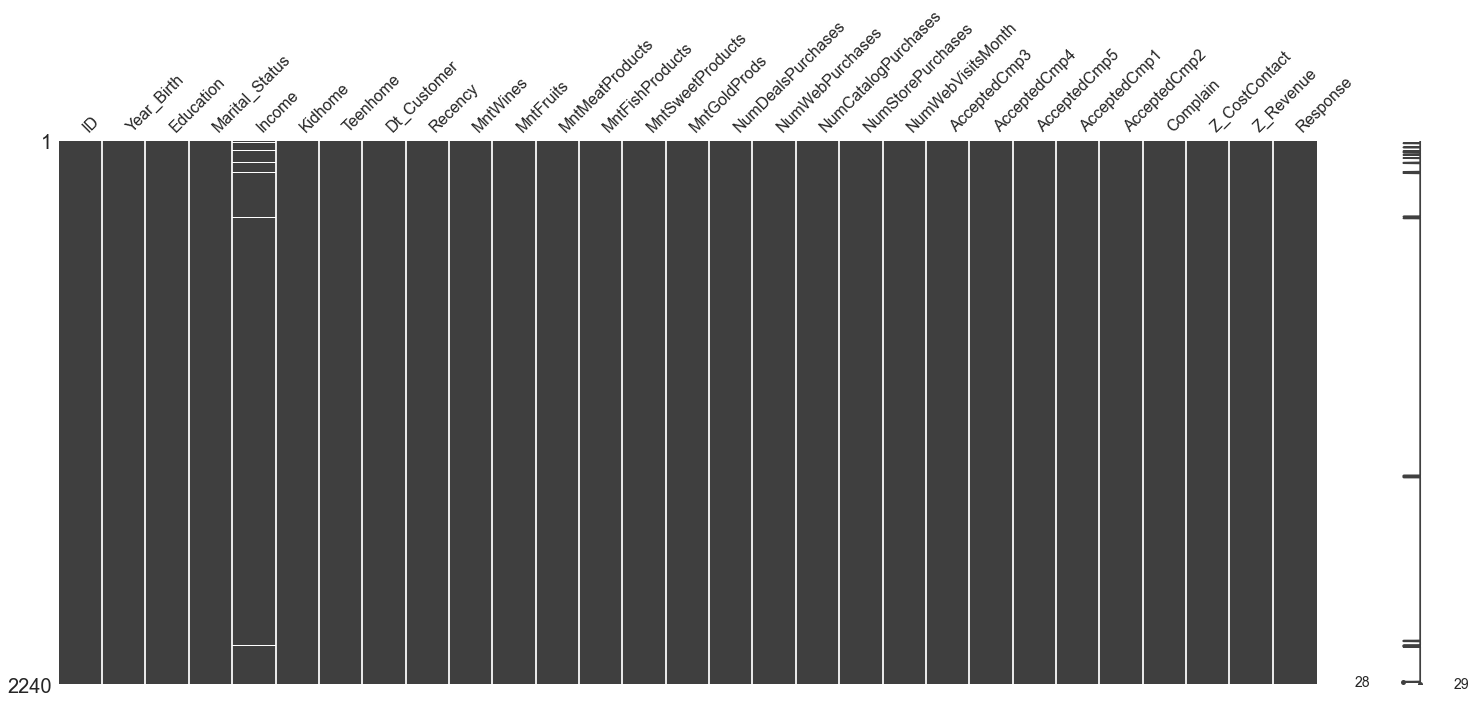

In [98]:
msno.matrix(data)

In [99]:
data.isna().sum().sort_values(ascending=False)[:6]

Income               24
ID                    0
NumDealsPurchases     0
Z_Revenue             0
Z_CostContact         0
Complain              0
dtype: int64

_As we can see, there are 24 missing values in 'Income' field_

In [100]:
data.dropna(inplace=True)

_Lets correct the type of __Dt_Costumer__ and create a list with the values._

In [101]:
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
dates =[]
for i in data['Dt_Customer']:
    i=i.date()
    dates.append(i)

# Fechas del cliente más antiguo y el más reciente
print('The oldest client suscribed in:', min(dates))
print('The newest client suscribed in:', max(dates))

The oldest client suscribed in: 2012-01-08
The newest client suscribed in: 2014-12-06


_For simplicity and data integrity, will create a _feature_ called ___Costumer_for___ , which counts the days since client subscription till the latest subscription_

In [102]:
days = []

for i in dates:
    delta = max(dates) - i
    days.append(delta)

data['Costumer_for'] = days
print(data['Costumer_for'][:4])
data['Costumer_for'] =pd.to_numeric(data['Costumer_for'])
data['Costumer_for'][:4]

0   971 days
1   125 days
2   472 days
3    65 days
Name: Costumer_for, dtype: timedelta64[ns]


0    83894400000000000
1    10800000000000000
2    40780800000000000
3     5616000000000000
Name: Costumer_for, dtype: int64

## ___Feature Engineering___

### Marital_Status

In [103]:
# Different values to this feature
data['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

_To simplify this feature, will create a new _feature_ called __Living_with___

In [104]:
data['Living_with'] = data['Marital_Status'].replace({'Married':'Partner', 
                                                        'Together':'Partner',
                                                        'Single':'Alone',
                                                         'Divorced':'Alone',
                                                          'Widow':'Alone',
                                                          'Absurd':'Alone',
                                                          'YOLO':'Alone' })

In [105]:
data['Living_with'][:3]

0      Alone
1      Alone
2    Partner
Name: Living_with, dtype: object

### Education

In [106]:
# Different values to this feature
data.Education.value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

_Will segment this in 3 groups, __undergraduated__, __graduated__ and __postgraduated___

In [107]:
data['Education'] = data.Education.replace({'Graduation':'Graduate',
                                             'PhD':'PostGraduate', 
                                             'Master':'PostGraduate',
                                             '2n Cycle': 'Undergraduate',
                                             'Basic':'Undergraduate'})

### Children

_Let's merge __kidhome__ and __teenhome__ in __Children___

In [108]:
data['Children']= data.Kidhome + data.Teenhome

### Age

In [109]:
data['Age'] = 2022 - data.Year_Birth
data['Age'][:4]

0    65
1    68
2    57
3    38
Name: Age, dtype: int64

### Spent

_This feature indicates the total spent in various categories for each costumer in the period of two years_ 

In [110]:
data['Spent'] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

### Family_Size

_This feature will indicate how many persons are living together_

In [111]:
data['Family_Size'] = data.Living_with.replace({'Alone':1, 'Partner':2})+data.Children
data['Family_Size'][:4]

0    1
1    3
2    2
3    3
Name: Family_Size, dtype: int64

### Is_Parent

In [112]:
data['Is_Parent'] = np.where(data.Children>0, 1, 0)
data.Is_Parent[:4]

0    0
1    1
2    0
3    1
Name: Is_Parent, dtype: int32

In [113]:
#For clarity
data=data.rename(columns={"MntWines": "Wines",
                        "MntFruits":"Fruits",
                        "MntMeatProducts":"Meat",
                        "MntFishProducts":"Fish",
                        "MntSweetProducts":"Sweets",
                        "MntGoldProds":"Gold"})

_And finally, lets drop what won't be needed_

In [115]:
drop = ['Marital_Status',  'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data.drop(drop, axis=1, inplace=True)

_Let's check some numerical values now_

In [117]:
data.select_dtypes(include=np.number).describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Costumer_for,Children,Age,Spent,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,0.947202,53.179603,607.075361,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,0.749062,11.985554,602.900476,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,26.000000,5.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,0.000000,45.000000,69.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,1.000000,52.000000,396.500000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,1.000000,63.000000,1048.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,3.000000,129.000000,2525.000000,5.000000,1.000000


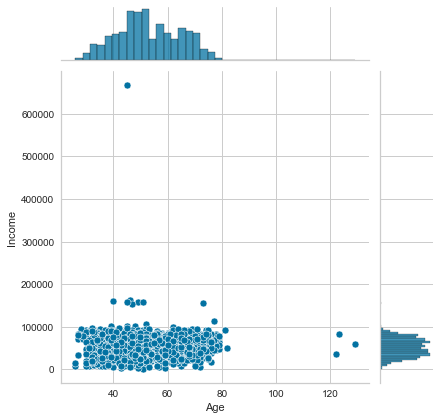

In [120]:
sns.jointplot(x=data.Age, y=data.Income, palette='dark')